<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка текста</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-функций" data-toc-modified-id="Подготовка-функций-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка функций</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
from catboost import CatBoostClassifier, Pool
import spacy

import re 
import nltk 

from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from nltk.corpus import stopwords


nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger')
from nltk.corpus import wordnet

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
#загрузим датасет
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Проверим на наличие дубликатов.

In [5]:
df.duplicated().sum()

0

Дубликатов нет.

### Вывод

 Наши данные состоят из 3 столбцов и 159 тысяч 929 строк. Столбец **toxic** содержит числовой тип данных, столбец **text** содержит строковый тип данных. 

## Предобработка текста

Объявим корпус текстов, переведем его в тип юникод.

In [6]:
#corpus = df['text'].values.astype('U')
#print(corpus[1])

In [7]:
#df_corpus = pd.DataFrame(data=corpus, columns=['text'])
#df_corpus.head(3)

Приведем текст к нижнему регистру

In [8]:
df['clear_text'] = df['text'].str.lower()
df.head(3)

,Unnamed: 0,text,toxic,clear_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation\nwhy the edits made under my usern...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww! he matches this background colour i'm s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm really not trying to edit war. it..."


Уберем лишние знаки - **'**, **.**, **!** и так далее. 

In [9]:
df['clear_text'] = df['clear_text'].apply(lambda x:re.sub(r"[^a-zA-Z0-9']", ' ', x))
df.head(3)

,Unnamed: 0,text,toxic,clear_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it...


Лемматизируем текст

In [10]:
#sample_size = 2000
#df = df.sample(n=sample_size,random_state=0).reset_index(drop=True)
#df.shape

Лемматизируем текст

In [11]:
L = WordNetLemmatizer()

In [12]:
def lemmatizered(corpus):
  ''' функция выполняет токенизациию и лемматизацию массива текстов'''
  corpus_new = []
  for sentence in corpus:
    word_list = nltk.word_tokenize(sentence)
    corpus_new.append(' '.join([L.lemmatize(w) for w in word_list]))
  return corpus_new

In [13]:
nltk.download('stopwords')
stopwords.words('english')[:5]

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

In [14]:
def get_wordnet_pos(word):
    """функция возвращает словарь, где возвращается значение часть речи (pos_tag)"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
 
    return tag_dict.get(tag, wordnet.NOUN)

In [15]:
def get_word_text(corpus):
  ''' функция выполняет токенизациию и лемматизацию массива текстов c учетом pos_tag и удаление стоп-слов'''
  corpus_new = []
  for sentence in corpus:
    corpus_new.append(' '.join([L.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) if not w in stopwords.words('english')]))
  return corpus_new

In [16]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [17]:
%%time
df['clear_text'] = get_word_text(df['clear_text'])
df.head(3)

CPU times: user 28min 45s, sys: 3min 40s, total: 32min 25s
Wall time: 32min 28s


,Unnamed: 0,text,toxic,clear_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww match background colour 'm seemingly stu...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man 'm really try edit war 's guy constant...


In [18]:
#m = WordNetLemmatizer()
#df_corpus['text'] = df_corpus['text'].apply(lambda x: m.lemmatize(x))
#df_corpus.head(3)

Объединим наш корпус с датасетом

In [19]:
#df['lemm_text'] = df_corpus['text']
#df.head(10)

Посмотрим на распределение классов

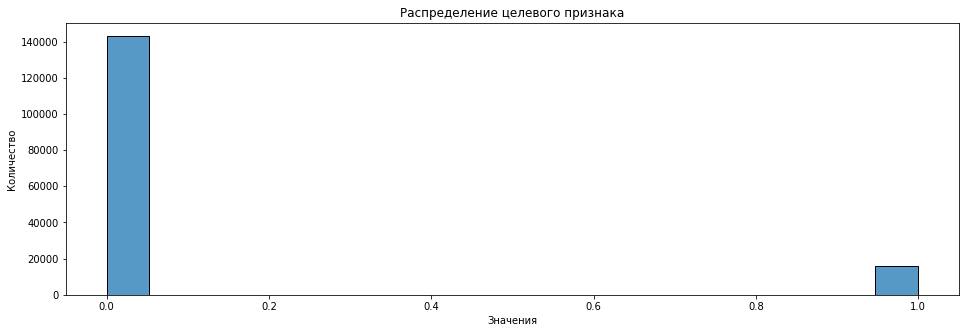

In [20]:
plt.figure(figsize=(16,5))
plt.title('Распределение целевого признака')
plt.xlabel('Значения')
plt.ylabel('Количество')
sns.histplot(df['toxic']);

 При разбивке надо будет учесть, что есть дисбаланс классов!

Определяем признаки и целевой признак, разделяем датасет на тренировочную и тестовую выборки

In [21]:
target = df['toxic']
features = df['clear_text']

In [22]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify = target)

Объявляю набор стоп-слов 

In [23]:
#nltk.download('stopwords')

In [24]:
#stopwords = set(stopwords.words('english'))

Объявляю TF-IDF-векторизатор

In [25]:
#count_tf_idf = TfidfVectorizer() 

In [26]:
#features_train = count_tf_idf.fit_transform(features_train)
#features_test = count_tf_idf.transform(features_test)

In [27]:
#display(features_train.shape)
#display(features_test.shape)

### Вывод

- объявлен корпус текстов и переведен в тип юникод
- текст очищен и лемматизирован
- таргет проверен на наличие дисбаланса - есть дисбаланс, учтен при разбивке на train и test
- выполнена векторизация текстов с помощью TfidfVectorizer()
- проведна разбивка на тренировочную и тестовую выборку с соотношением 1 к 4

## Обучение

### Подготовка функций

Для начала создадим наш DF куда положим значения RMSE

In [28]:
df_result = pd.DataFrame(columns=['f1'])
df_result

,f1


А теперь функцию которая будет в наш Df добавлять данные.

In [29]:
def result_metrics(f1, name_model):
    df_result.loc[name_model, 'f1'] = f1
    return df_result

### Логистическая регрессия

In [30]:
%%time
#Объявляю модель
regression = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=12345))])

#Определяю словарь с набором параметров
regression_parametrs = {'clf__C': [0.1, 1, 10],
          'clf__class_weight': ['balanced', None]}

#Применяю GridSearchCV с кросс-валидацией
regression_grid = GridSearchCV(estimator=regression, param_grid=regression_parametrs, cv=3, scoring='f1', n_jobs=-1, refit=False)
regression_grid.fit(features_train, target_train)

regression_params = regression_grid.best_params_
result_metrics(regression_grid.best_score_, 'LogisticRegression')
print(df_result)
print(f'best_params: {regression_params}')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

                          f1
LogisticRegression  0.774854
best_params: {'clf__C': 10, 'clf__class_weight': None}
CPU times: user 3min 38s, sys: 5min 53s, total: 9min 32s
Wall time: 9min 32s


### Случайный лес

In [31]:
%%time
#Объявляю модель
forest= Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=12345))])
#Определяю словарь с набором параметров
forest_parametrs = { 'clf__n_estimators': range(20, 40, 5),
                     'clf__max_depth': range(4, 8, 2),
                    'clf__class_weight': ['balanced', None]
                   }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(estimator=forest, param_grid=forest_parametrs, cv=3, scoring='f1', n_jobs=-1, refit=False)
forest_grid.fit(features_train, target_train)


result_metrics(forest_grid.best_score_, 'RandomForest')
forest_params = forest_grid.best_params_
print(df_result)
print(f'best_params: {forest_params}')

                          f1
LogisticRegression  0.774854
RandomForest          0.3154
best_params: {'clf__class_weight': 'balanced', 'clf__max_depth': 6, 'clf__n_estimators': 30}
CPU times: user 3min 27s, sys: 1.48 s, total: 3min 29s
Wall time: 3min 29s


### CatBoost

Отдельно сделал набор фичей и таргетов для обучения CatBoost с меньшим количеством так как CatBoost у меня падал с Dead Kernel из-за перегрузки ядра,при обучении модели пришлось уменьшить количество строк.

In [32]:
features_train_cb = features_train[:1800]
features_test_cb = features_test[:600]
target_train_cb = target_train[:1800]
target_test_cb = target_test[:600]

In [33]:
zeroes = df['toxic'].value_counts()[0]
ones = df['toxic'].value_counts()[1]

In [34]:
%%time
#Объявляю модель
cb= Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', CatBoostClassifier(random_state=12345, auto_class_weights = 'Balanced', iterations=30, verbose=False))])
#Определяю словарь
cb_parametrs = {'clf__depth': [4, 8]}

#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(estimator=cb, param_grid=cb_parametrs, cv=3, scoring='f1')
cb_grid.fit(features_train_cb, target_train_cb)


result_metrics(cb_grid.best_score_, 'CatBoost')
cb_params = cb_grid.best_params_
print(df_result)
print(f'best_params: {cb_params}')

                          f1
LogisticRegression  0.774854
RandomForest          0.3154
CatBoost             0.47335
best_params: {'clf__depth': 8}
CPU times: user 25.2 s, sys: 546 ms, total: 25.7 s
Wall time: 28.8 s


Опять обучим модель Логистическая регрессия на оптимальных параметрах

In [35]:
# %%time
regression = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(fit_intercept=True,
                                class_weight='balanced',
                                random_state=42,
                                solver='liblinear',
                                C=regression_params['clf__C']
                               ))])
regression.fit(features_train, target_train)
regression_model_predictions = regression.predict(features_test)
regression_f1 = round(f1_score(target_test, regression_model_predictions), 3) 
print(regression_f1)

0.768


Логистическая регрессия с оптимальными параметрами удовлетворяет условию задачи.

## Выводы

1. Предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159571 строк. 
 
2. Подготовка модели:
- Тексты комментариев были очищены и лемматизированы.
- В датасете есть дисбаланс классов. Мажорный класс составляет лишь 10% от всего датасета. 
- Проведена  векторизации датасета. Матрица полученная после векторизации разделена на обучающую и тестовые выборки в соотношении 4:1.

3. Обучение модели:
- Использованы Логистическая регрессия, Случайный лес и CatBoost классификатор.
- Наилучший - CatBoost, наихудший - Случайный лес. CatBoost выполняет расчеты в десятки раз дольше, нежели Логистическая регрессия, но значения полученные на тестовой выборке не удовлетворяет условию задачи. В связи с этим модель Логистическая регрессия подходит для решения поставленной задачи.